### Author: Nathaniel Ruhl
### This notebook performs the tanh() fit, reconstructs the curve, and performs the curve comparison. I think we will want to do the curve slide in the time domain, but this notebook does the slide in tangent altitude

Text(0.5, 0, 'Tangent Altitude (km)')

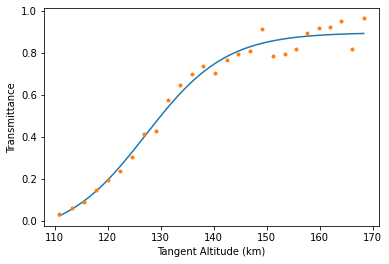

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

R_planet = 6368.16   # km, radius of Earth at tangent point (this is like 'y_0,ref' above)

## It is important to note that the data being readd into this file uses an ellipsoid Earth,
## so we're not looking for exact constistency... just order of magnitude.

timeTransmit = np.load("timeTransmit.npy")
time_data = timeTransmit[:,0]
transmit_data = timeTransmit[:,1]
timeAlt = np.load("timeAlt.npy")
time_crossing_model = timeAlt[:,0]
h_list = timeAlt[:,1]  # Note that this is "h" in my new notation

crossing_range = np.where((time_data>=time_crossing_model[0])&(time_data<=time_crossing_model[-1]))[0]
time_data = time_data[crossing_range]
transmit_data = transmit_data[crossing_range]

# 1) Since the transmit data doesnt correspond to time_crossing_model, we first need to interpolate h_list
# We can avoid this is the future by by definining time_crossing_model differently in another script so that instead of t0_model+[0:175:1], it is t0_model+[dt1:175+dt1:1] where dt1 = time_data[0] - t0_model... but the interpolation is fine for this example
h_vs_time = interp1d(time_crossing_model, h_list, "cubic")
time_vs_h = interp1d(h_list, time_crossing_model, "cubic")
h_data = h_vs_time(time_data)

w1 = np.where(transmit_data>=0.01)[0][0]  # can't go to zero
w2 = np.where(transmit_data >= 0.99)[0][0]  # could also use -1

transmit_measured = transmit_data[w1:w2]
h_measured = h_data[w1:w2]

# Transmittance fit
# we can fit to either y or h, the c parameter is the only thing that will change
def transmit_vs_h(h, a, b, c, d):
    return a*np.tanh(b*(h-c))+d

popt, pcov = curve_fit(transmit_vs_h, h_measured, transmit_measured, p0=[0.5, 1/50, 100, 0.5])
a, b, c, d = popt

h = np.linspace(np.min(h_measured), np.max(h_measured), 1000)
plt.plot(h, transmit_vs_h(h, *popt))
plt.plot(h_measured, transmit_measured, ".")   # fit y, plot h
plt.ylabel("Transmittance")
plt.xlabel("Tangent Altitude (km)")

Reconstruct model with h50_predict. Note that the model could potentially go negative, so we need to ensure a correct comparison while sliding the curve... we can pretend like we did not previosuly have a weight range and just use comp_range like normal.

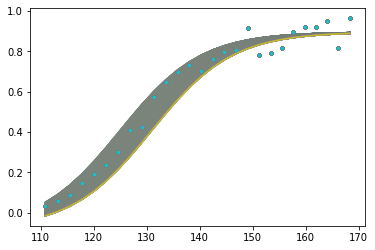

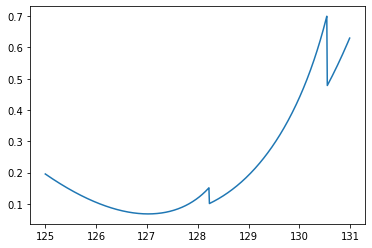

In [11]:
h50_predict = 128
c = h50_predict - (1/b)*np.arctanh((0.5-d)/a)
c_slide = np.arange(h50_predict-3, h50_predict+3, 0.01)
chisq_list = []
plt.figure(1)
for c in c_slide:
    transmit_model = transmit_vs_h(h_measured, a, b, c, d)   # model data points that correspond to h_measured
    chisq_terms = (transmit_measured - transmit_model)**2/transmit_model # individual terms in chi-squared
    comp_range = np.where((transmit_model>0.01)&(transmit_model<0.99))[0]
    chisq = np.sum(chisq_terms[comp_range])
    chisq_list.append(chisq)
    plt.plot(h_measured, transmit_model)
    plt.plot(h_measured, transmit_measured, '.')
    
plt.figure(2)
plt.plot(h50_slide, chisq_list)

In [13]:
h50_slide[np.argmin(chisq_list)]

127.03000000000104